In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression,LogisticRegression,SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing,utils,svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

In [2]:
df = pd.read_csv('train.csv')

#Basic dataframe info
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5847 entries, 0 to 5846
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5847 non-null   int64  
 1   Name               5847 non-null   object 
 2   Location           5847 non-null   object 
 3   Year               5847 non-null   int64  
 4   Kilometers_Driven  5847 non-null   int64  
 5   Fuel_Type          5847 non-null   object 
 6   Transmission       5847 non-null   object 
 7   Owner_Type         5847 non-null   object 
 8   Mileage            5845 non-null   object 
 9   Engine             5811 non-null   object 
 10  Power              5811 non-null   object 
 11  Seats              5809 non-null   float64
 12  New_Price          815 non-null    object 
 13  Price              5847 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 639.6+ KB


In [3]:
#Data cleaning
df = df.drop(columns=['New_Price'])
df_cleaned = df.dropna()


#Setting all of the names to just the first word aka the make instead of the make and model
df_cleaned['Name'] = df_cleaned['Name'].str.split().str[0]
Brands = np.unique(df_cleaned['Name'])
print(Brands)

#Converting the price to USD
conversion_factor = 100000 / 1198.32
df_cleaned['Price'] = df_cleaned['Price'] * conversion_factor
Unique_prices = np.unique(df_cleaned['Price'])
print(Unique_prices)
df_cleaned = df_cleaned[df_cleaned['Price'] >= 100] #Considering any cars sold under $100 to be noise

# Removing noise from Kilometers_Driven as there is one with over 6 million
df_cleaned = df_cleaned[df_cleaned['Kilometers_Driven'] <= 1000000]

# Removing the text part (' kmpl' and ' km/kg') and converting the column to float
df_cleaned['Mileage'] = df_cleaned['Mileage'].str.replace(' kmpl', '', regex=False)
df_cleaned['Mileage'] = df_cleaned['Mileage'].str.replace(' km/kg', '', regex=False)
df_cleaned['Mileage'] = df_cleaned['Mileage'].astype(float)
df_cleaned = df_cleaned[df_cleaned['Mileage'] >= 5] #All cares with mileage under 5 were 0 in the dataset so I threw them out

#Separating engine col into int value 
df_cleaned['Engine'] = df_cleaned['Engine'].str.replace(' CC', '', regex=False)
df_cleaned['Engine'] = df_cleaned['Engine'].astype(int)

#Cleaning horsepower col to float
df_cleaned['Power'] = df_cleaned['Power'].str.replace(' bhp', '', regex=False)
df_cleaned['Power'] = df_cleaned['Power'].astype(float)

['Ambassador' 'Audi' 'BMW' 'Bentley' 'Chevrolet' 'Datsun' 'Fiat' 'Force'
 'Ford' 'Honda' 'Hyundai' 'ISUZU' 'Jaguar' 'Jeep' 'Lamborghini' 'Land'
 'Mahindra' 'Maruti' 'Mercedes-Benz' 'Mini' 'Mitsubishi' 'Nissan'
 'Porsche' 'Renault' 'Skoda' 'Tata' 'Toyota' 'Volkswagen' 'Volvo']
[   36.71807197    37.5525736     41.72508178 ...  8345.01635623
 10014.01962748 13352.02616997]


C:\Users\Henry\AppData\Local\Temp\ipykernel_8436\3899637171.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Name'] = df_cleaned['Name'].str.split().str[0]
C:\Users\Henry\AppData\Local\Temp\ipykernel_8436\3899637171.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['Price'] = df_cleaned['Price'] * conversion_factor


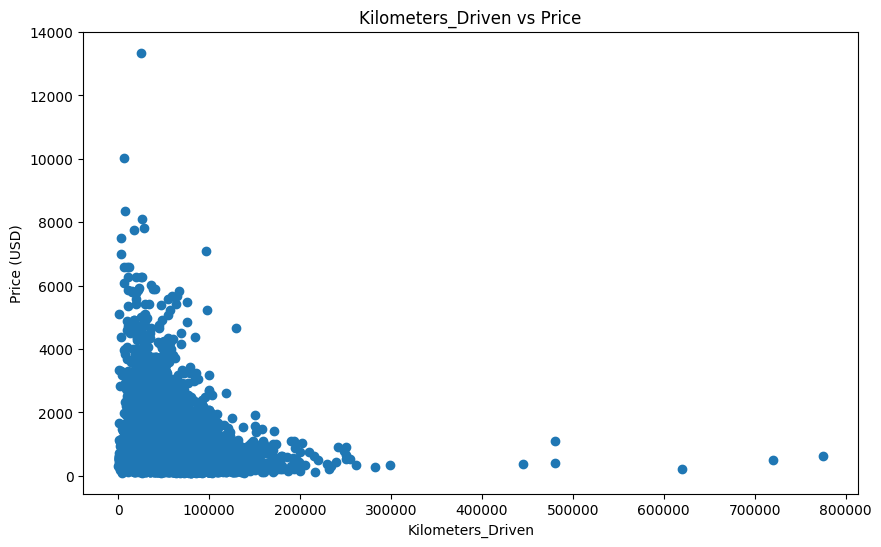

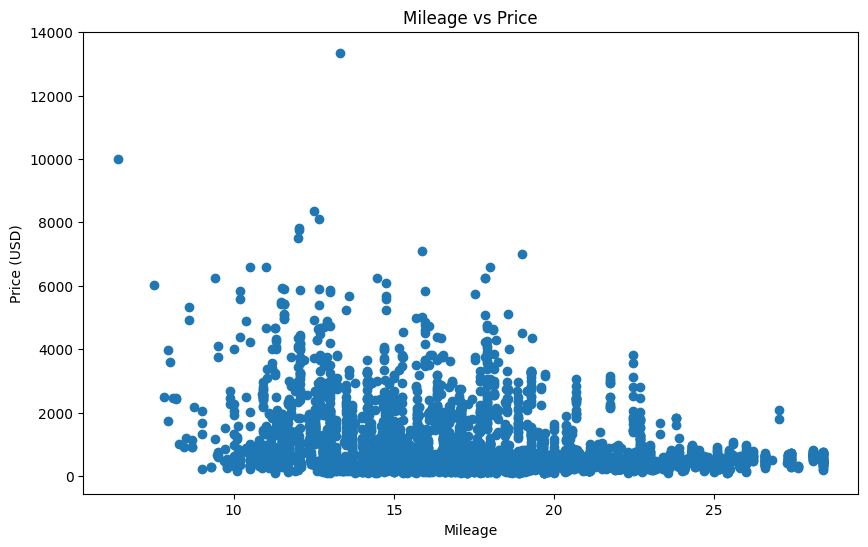

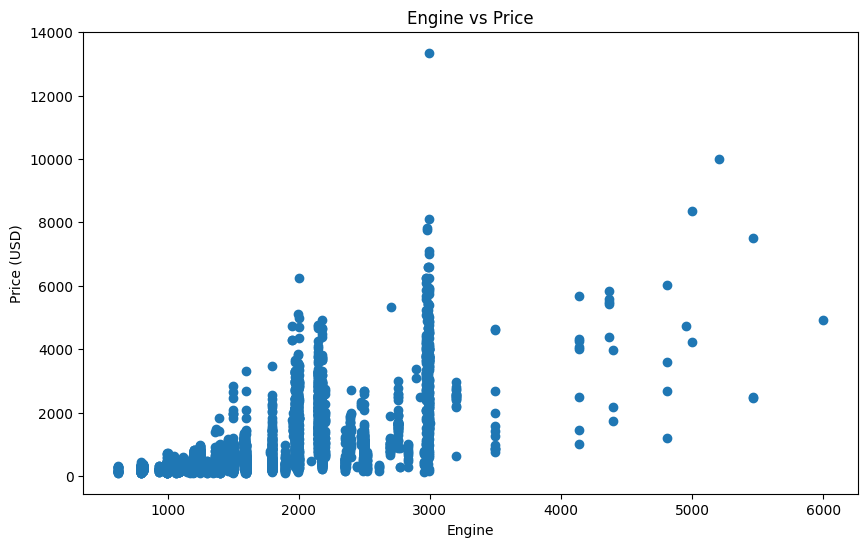

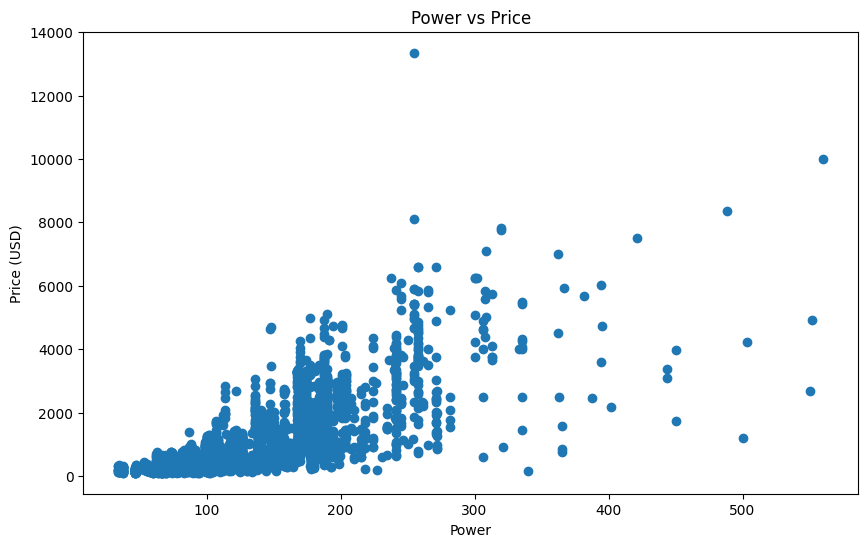

In [4]:
numerical_columns = np.array(["Kilometers_Driven", "Mileage", "Engine", "Power"])

# Plotting each numerical feature against Price
for col in numerical_columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(df_cleaned[col], df_cleaned['Price'])
    plt.xlabel(col)
    plt.ylabel('Price (USD)')
    plt.title(f'{col} vs Price')
    plt.show()

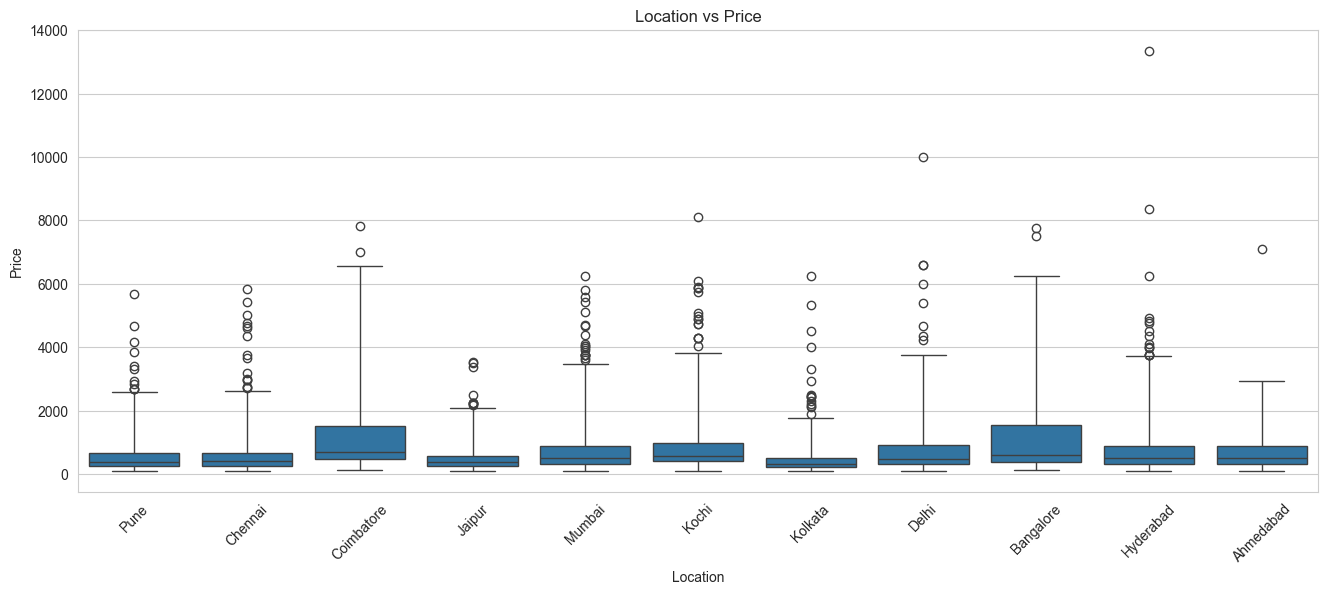

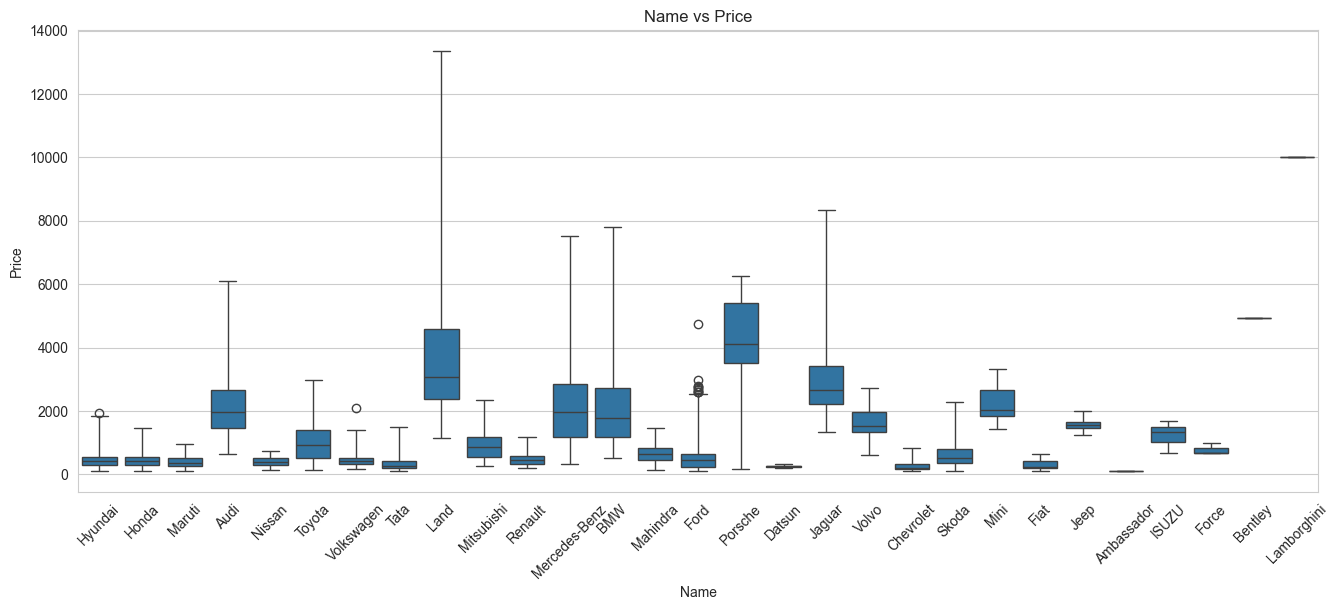

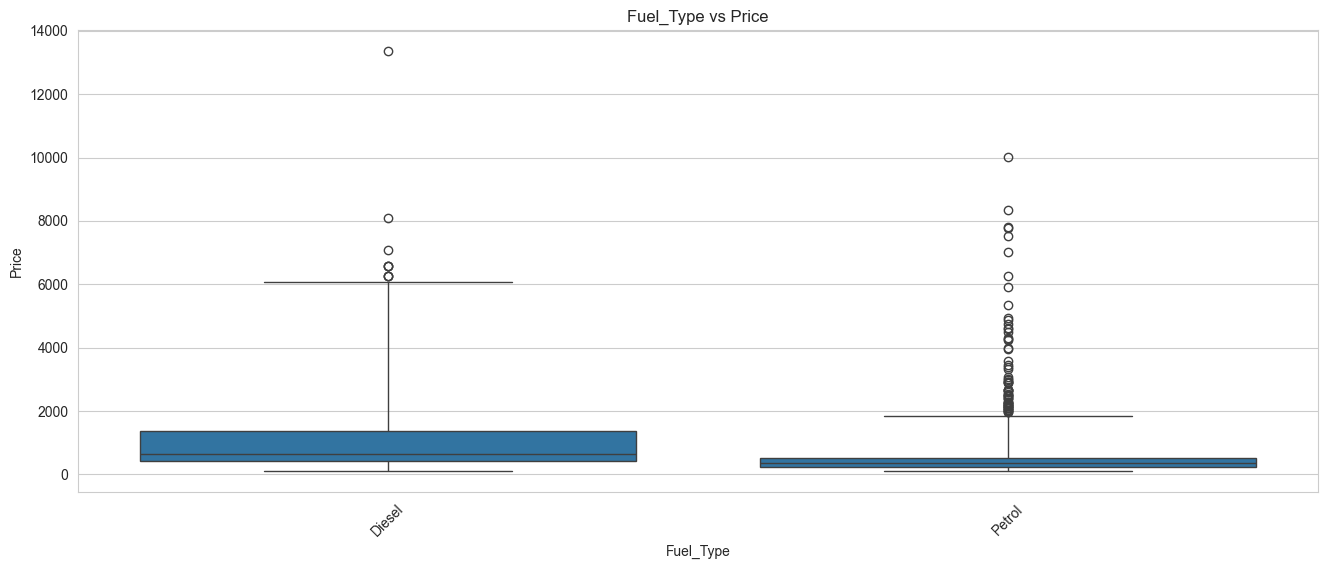

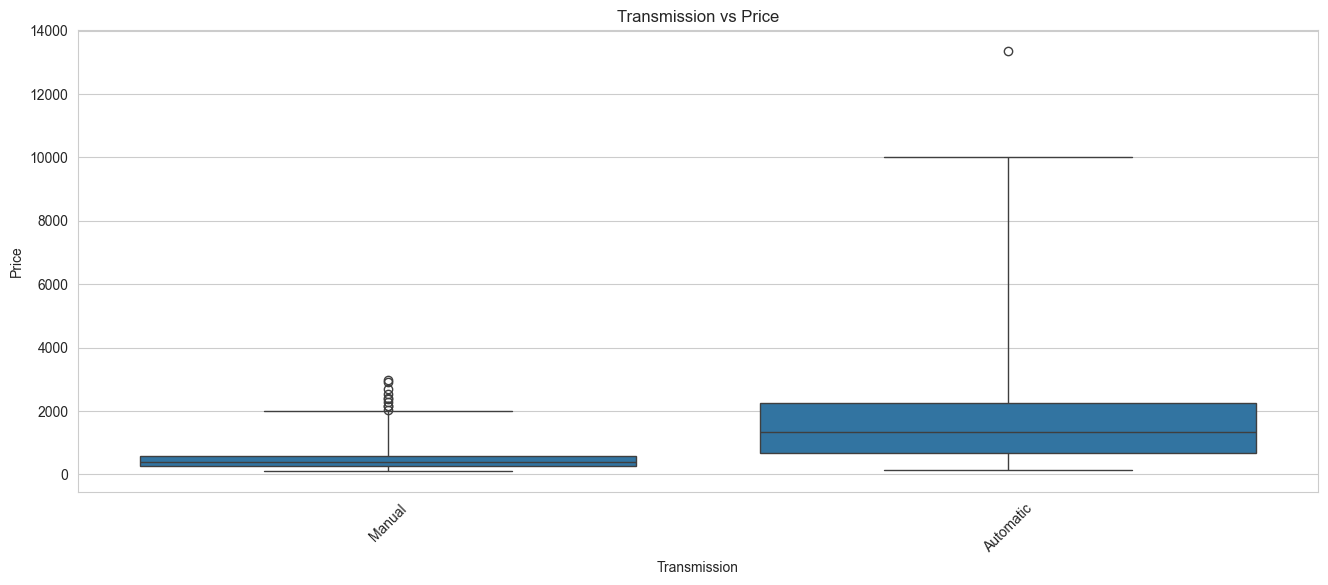

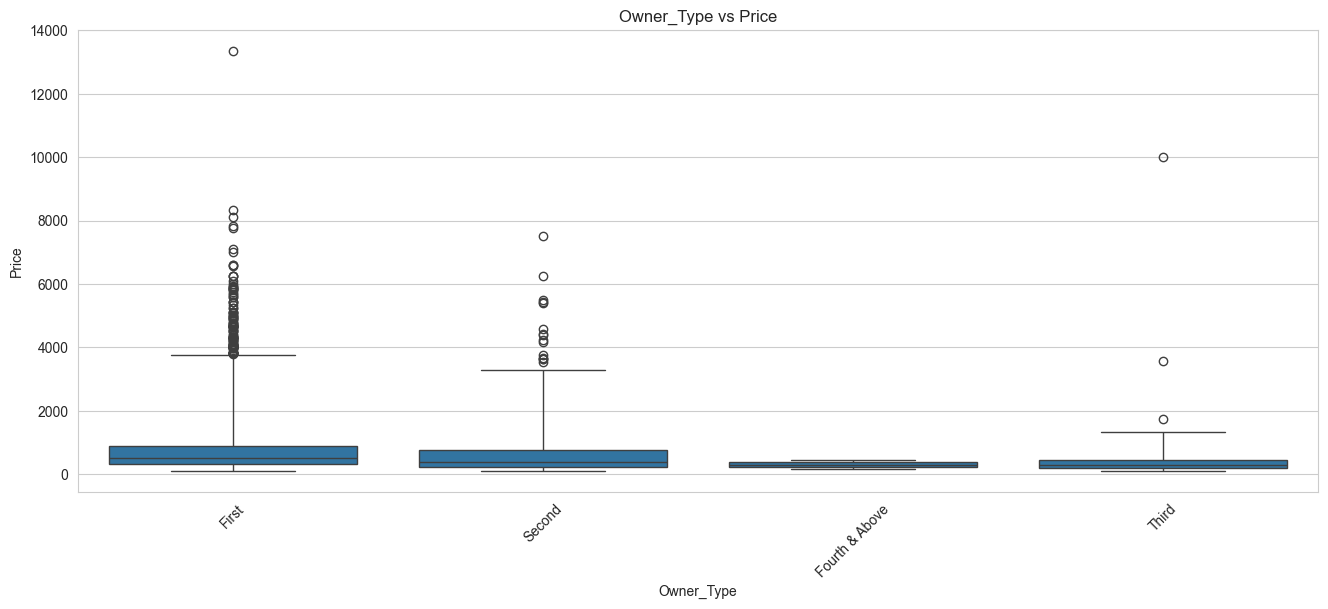

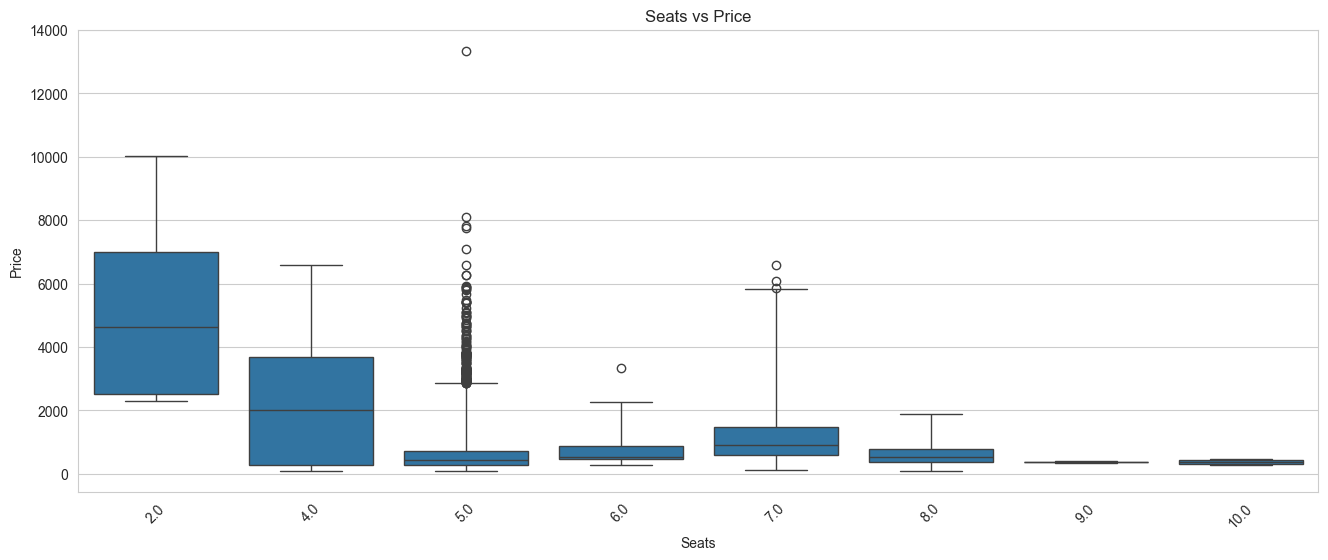

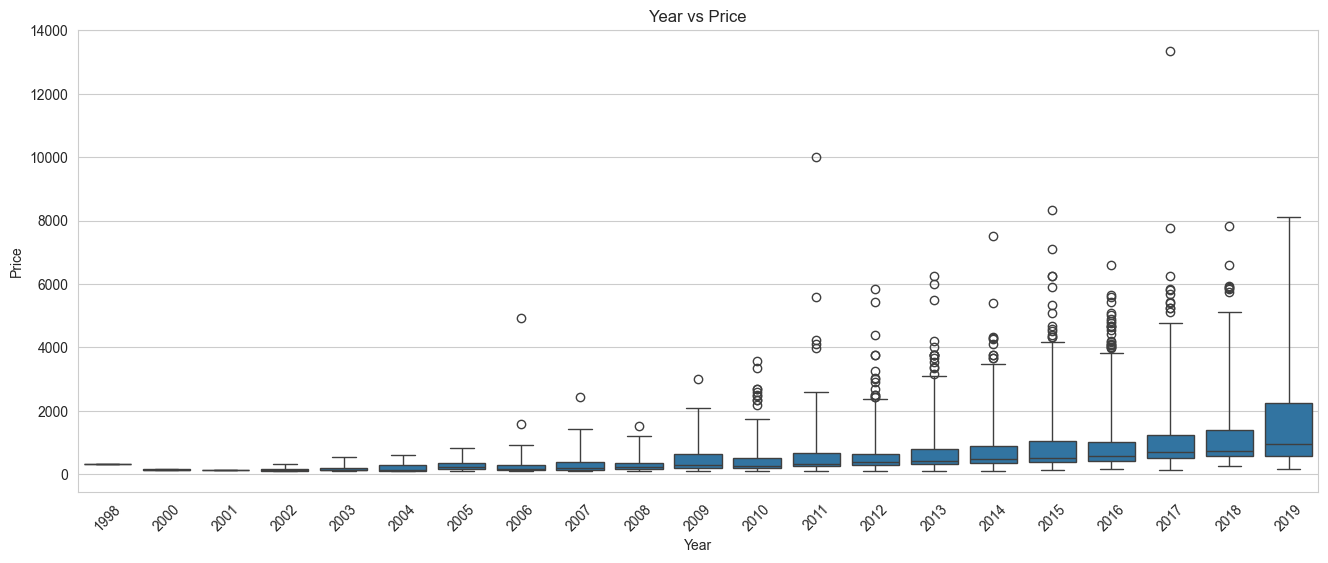

In [5]:
categorical_columns = np.array(["Location", "Name", "Fuel_Type", "Transmission", "Owner_Type", "Seats", "Year"])

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Plotting each categorical feature against Price using boxplots
for col in categorical_columns:
    plt.figure(figsize=(16, 6))
    sns.boxplot(x=col, y='Price', data=df_cleaned, whis=5)
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.title(f'{col} vs Price')
    plt.xticks(rotation=45) 
    plt.show()

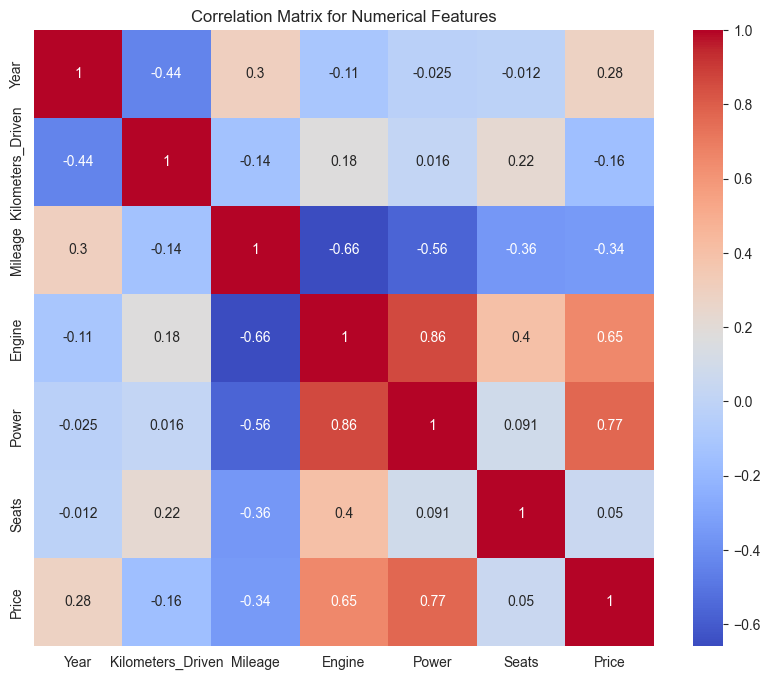

In [6]:
numerical_features = ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats', 'Price']

corr_matrix = df_cleaned[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Features')
plt.show()


In [7]:
#Try linear regression function so I can try with a bunch of different params
def tryLR(num_cols):
    X = df_cleaned[num_cols]
    y = df_cleaned['Price']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    print(f'R-squared: {r2}')

In [8]:
tryLR(['Kilometers_Driven', 'Mileage', 'Engine', 'Power'])

tryLR(['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats'])
tryLR(['Year', 'Kilometers_Driven', 'Engine', 'Power', 'Seats'])
tryLR(['Year', 'Kilometers_Driven', 'Engine', 'Power'])

Mean Squared Error: 357481.6969076514
R-squared: 0.6237929632778756
Mean Squared Error: 277508.4711122018
R-squared: 0.7079552869824868
Mean Squared Error: 277192.948983037
R-squared: 0.7082873365566612
Mean Squared Error: 278577.2281470531
R-squared: 0.7068305471131859


In [9]:
#arr= ['Year', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power', 'Seats']
arr= ['Year', 'Kilometers_Driven', 'Engine', 'Power', 'Seats']
X = df_cleaned[arr]
y = df_cleaned['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(y_pred)
print(y_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

[442.08473937 198.33152061  62.76143021 ...  54.94144852 750.39710631
 402.1955538 ]
1153    546.598571
954     204.452901
1825    233.660458
3864    383.870752
5102    605.013686
           ...    
5801    292.075572
3740    502.369985
2191    221.142933
5563    500.700981
1095    420.588824
Name: Price, Length: 1137, dtype: float64
Mean Squared Error: 277192.948983037
R-squared: 0.7082873365566612


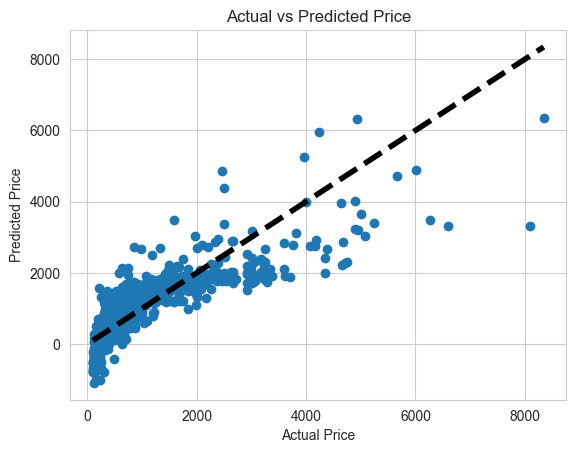

In [10]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Actual vs Predicted Price')
plt.show()

In [11]:
arr= ['Year', 'Kilometers_Driven', 'Engine', 'Power', 'Seats']
X = df_cleaned[arr]
y = df_cleaned['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor()
#lab = preprocessing.LabelEncoder()
#y_transformed = lab.fit_transform(y_train)
#y_transformed = y_train.astype(int)
#lab = preprocessing.LabelEncoder()
#y_transformed = lab.fit_transform(y_transformed)
#print(y_transformed)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 92091.71818347185
R-squared: 0.9030844020710718


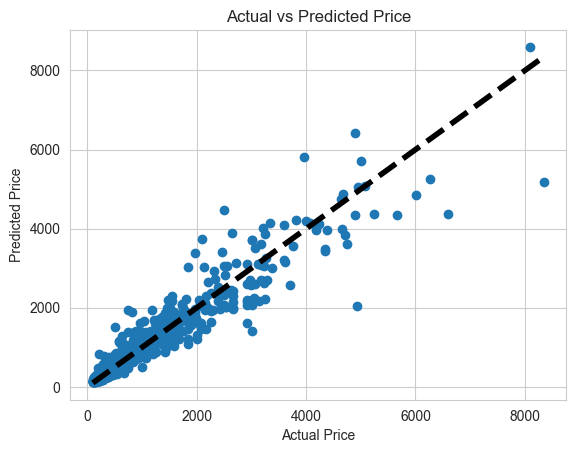

In [12]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Actual vs Predicted Price')
plt.show()

In [13]:
#Random search for hyperparam selection
param_dist = {
    'n_estimators': sp_randint(100, 1000),
    'max_depth': [3, 10, 20, 30, None],
    'min_samples_split': sp_randint(2, 11),
    'min_samples_leaf': sp_randint(1, 11),
    'max_features': ['sqrt', 'log2', None], 
    'bootstrap': [True, False]
}

rf = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_params = random_search.best_params_
print("Best parameters found:", best_params)
best_rf = RandomForestRegressor(**best_params)
best_rf.fit(X_train, y_train)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found: {'bootstrap': True, 'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 526}


RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=4,
                      n_estimators=526)

Mean Squared Error: 90797.1807685932
R-squared: 0.9044467489799912


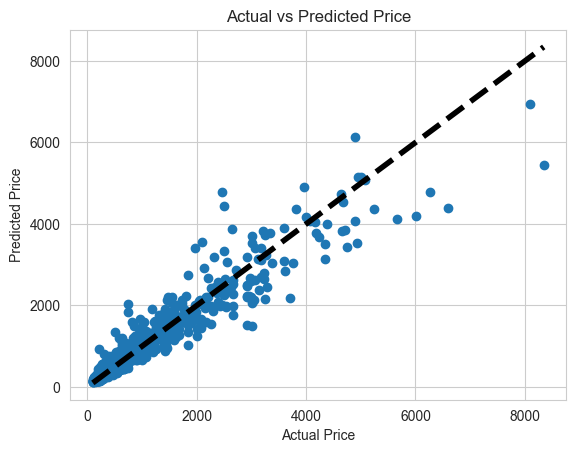

In [14]:
#Trying random forest again with 
arr= ['Year', 'Kilometers_Driven', 'Engine', 'Power', 'Seats']
X = df_cleaned[arr]
y = df_cleaned['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_split=4, n_estimators=526)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

plt.scatter(y_test, y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.title('Actual vs Predicted Price')
plt.show()